In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the feature engineered dataset
df = pd.read_csv('/kaggle/input/02-feature-engineering-caiso-renewables/CAISO_Renewables_Featured.csv', parse_dates=['DateTime'])
df.set_index('DateTime', inplace=True)
df = df.asfreq('H')
df.head()


,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural Gas,Large Hydro,...,Imports,Other,Month,Year,year,month,day,hour,dayofweek,is_weekend
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,-34.0,4547.0,928.0,281.0,195.0,168.0,18.0,2263.0,8875.0,1261.0,...,8145.0,0.0,9,2021,2021,9,1,0,2,0
2021-09-01 01:00:00,-36.0,4346.0,931.0,282.0,215.0,140.0,19.0,2260.0,8734.0,968.0,...,7008.0,0.0,9,2021,2021,9,1,1,2,0
2021-09-01 02:00:00,-36.0,3931.0,930.0,282.0,216.0,139.0,18.0,2261.0,8517.0,926.0,...,6598.0,0.0,9,2021,2021,9,1,2,2,0
2021-09-01 03:00:00,-37.0,3880.0,931.0,281.0,215.0,137.0,18.0,2257.0,8205.0,936.0,...,6221.0,0.0,9,2021,2021,9,1,3,2,0
2021-09-01 04:00:00,-37.0,3915.0,930.0,279.0,216.0,158.0,19.0,2255.0,8080.0,1138.0,...,6383.0,0.0,9,2021,2021,9,1,4,2,0


In [3]:
target = 'Solar'  # Use the correct column name

# Drop NaNs if any
df = df[[target]].dropna()

# Split data: last 30 days as test
train = df.iloc[:-24*30]
test = df.iloc[-24*30:]

print(f"Train size: {train.shape}, Test size: {test.shape}")

Train size: (8039, 1), Test size: (720, 1)


In [4]:
naive_forecast = test.copy()
naive_forecast[target] = train[target].iloc[-1]

mae_naive = mean_absolute_error(test[target], naive_forecast[target])
rmse_naive = mean_squared_error(test[target], naive_forecast[target], squared=False)

print(f"Naive MAE: {mae_naive:.2f}")
print(f"Naive RMSE: {rmse_naive:.2f}")


Naive MAE: 5195.42
Naive RMSE: 7622.27


12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:13 - cmdstanpy - INFO - Chain [1] done processing


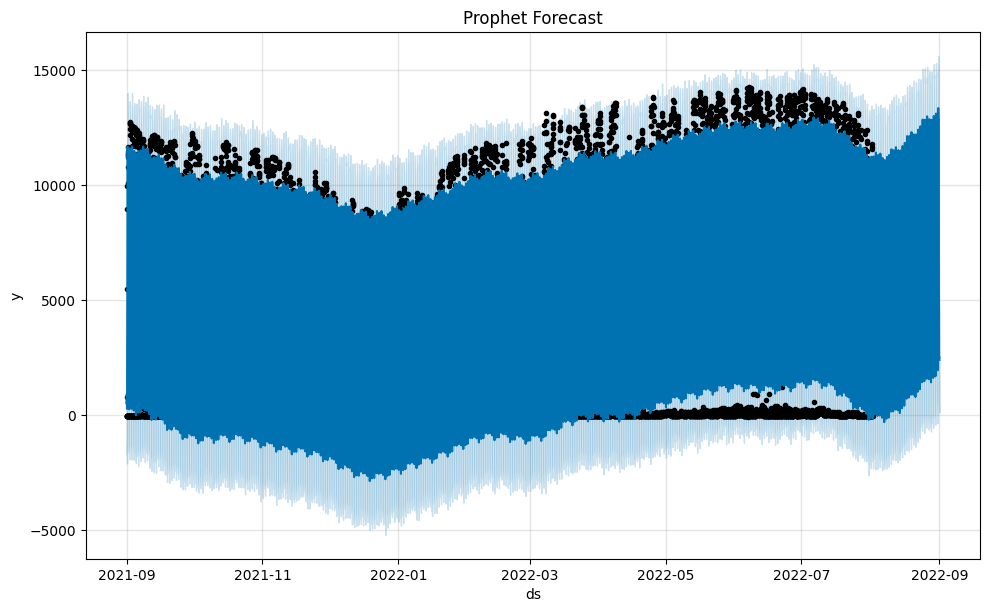

Prophet MAE: 1305.26
Prophet RMSE: 1599.31


In [7]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Reset the index of the training data
df_prophet = train.reset_index()

# Rename the columns to 'ds' and 'y'
df_prophet = df_prophet.rename(columns={'DateTime': 'ds', target: 'y'})

model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=24*30, freq='H')
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Evaluation
forecast_test = forecast.set_index('ds')[['yhat']].iloc[-24*30:]
mae_prophet = mean_absolute_error(test[target], forecast_test['yhat'])
rmse_prophet = mean_squared_error(test[target], forecast_test['yhat'], squared=False)

print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")

In [8]:
from xgboost import XGBRegressor

# Create time features
def create_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

X_train = create_time_features(train)
X_test = create_time_features(test)

features = ['hour', 'dayofweek', 'month']
y_train = train[target]
y_test = test[target]

model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train[features], y_train)

pred_xgb = model_xgb.predict(X_test[features])

mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = mean_squared_error(y_test, pred_xgb, squared=False)

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")


XGBoost MAE: 810.89
XGBoost RMSE: 1247.14


In [9]:
results = pd.DataFrame({
    'Model': ['Naive', 'Prophet', 'XGBoost'],
    'MAE': [mae_naive, mae_prophet, mae_xgb],
    'RMSE': [rmse_naive, rmse_prophet, rmse_xgb]
})

results.sort_values('RMSE')

,Model,MAE,RMSE
2,XGBoost,810.885703,1247.135191
1,Prophet,1305.258101,1599.307288
0,Naive,5195.418056,7622.274291


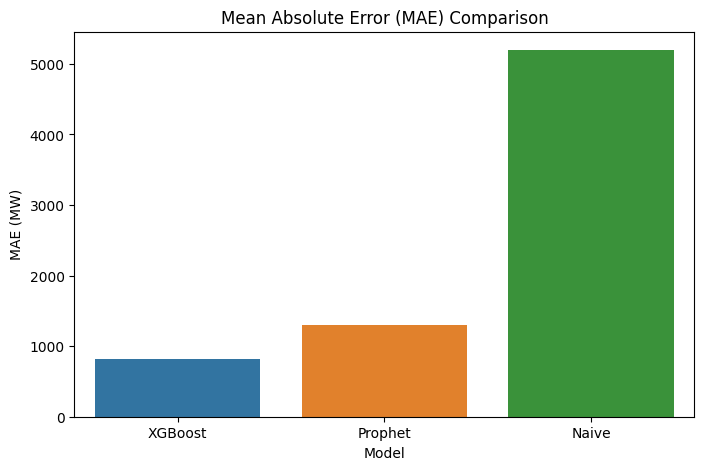

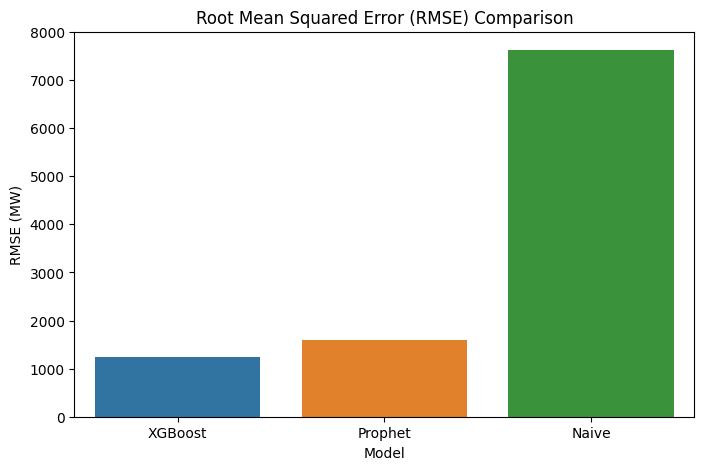

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for MAE
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MAE', data=results.sort_values('MAE'))
plt.title('Mean Absolute Error (MAE) Comparison')
plt.ylabel('MAE (MW)')
plt.show()

# Bar chart for RMSE
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='RMSE', data=results.sort_values('RMSE'))
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.ylabel('RMSE (MW)')
plt.show()

In [11]:
# Make predictions on the test set (you've already done this)
pred_xgb = model_xgb.predict(X_test[features])

# Create a pandas Series with the predictions and the test set's index
xgb_forecast = pd.Series(pred_xgb, index=y_test.index)

# Convert the Series to a DataFrame
xgb_forecast_df = pd.DataFrame({'DateTime': xgb_forecast.index, 'XGBoost_Forecast': xgb_forecast.values})

# Set 'DateTime' as the index for saving (optional, depends on your needs)
# xgb_forecast_df.set_index('DateTime', inplace=True)

# Save the DataFrame to a CSV file
xgb_forecast_df.to_csv('xgboost_forecast.csv', index=False) # index=False prevents writing the DataFrame index to the CSV

print("XGBoost forecast saved to xgboost_forecast.csv")

XGBoost forecast saved to xgboost_forecast.csv
